In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv("/Users/mohammedchowdhury/Desktop/TKH/EPP 2 Project/btc-usd-max (1).csv")

In [4]:
df = df.sort_values("snapped_at")
df = df.rename(columns={"snapped_at":"Date", "price":"Close", 
                        "market_cap":"MarketCap", "total_volume":"Volume"})

In [5]:
df.head()

,Date,Close,MarketCap,Volume
0,2013-04-28 00:00:00 UTC,135.30,1.500518e+09,0.0
1,2013-04-29 00:00:00 UTC,141.96,1.575032e+09,0.0
2,2013-04-30 00:00:00 UTC,135.30,1.501657e+09,0.0
3,2013-05-01 00:00:00 UTC,117.00,1.298952e+09,0.0
4,2013-05-02 00:00:00 UTC,103.43,1.148668e+09,0.0


In [6]:
df.count()

Date         4496
Close        4496
MarketCap    4496
Volume       4496
dtype: int64

In [7]:
df_clean = df[(df["Close"] != 0) & 
                    (df["MarketCap"] != 0) & 
                    (df["Volume"] != 0)]


df_clean.count()

Date         4254
Close        4254
MarketCap    4254
Volume       4254
dtype: int64

In [8]:
(df_clean==0).sum()

Date         0
Close        0
MarketCap    0
Volume       0
dtype: int64

In [9]:
df_clean.isna().sum()

Date         0
Close        0
MarketCap    0
Volume       0
dtype: int64

In [10]:
df_clean.describe()

,Close,MarketCap,Volume
count,4254.000000,4.254000e+03,4.254000e+03
mean,22801.334962,4.382969e+11,1.840388e+10
std,28399.335747,5.611329e+11,2.095922e+10
min,172.147900,2.362640e+09,2.642092e+06
25%,817.333750,1.191032e+10,8.936720e+08
50%,9284.507343,1.684121e+11,1.349019e+10
75%,36458.202202,6.916766e+11,2.932690e+10
max,123560.993636,2.458895e+12,1.904603e+11


In [11]:
print(df["Date"].min(), df["Date"].max())
print("Total days:", df["Date"].nunique())

2013-04-28 00:00:00 UTC 2025-08-20 00:00:00 UTC
Total days: 4496


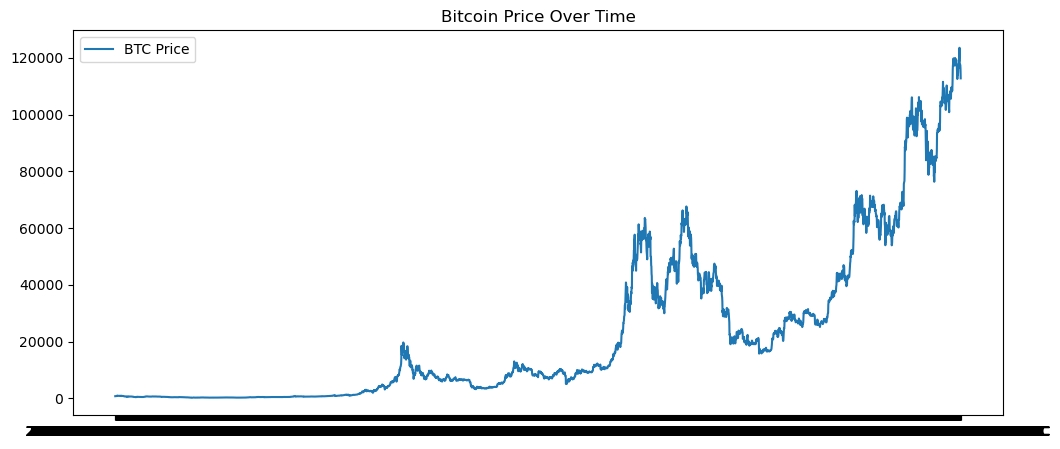

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df_clean["Date"], df_clean["Close"], label="BTC Price")
plt.title("Bitcoin Price Over Time")
plt.legend()
plt.show()


In the early years, the price was so low—just a few hundred to a couple of thousand dollars—that the line looks almost flat when compared to the massive spikes that came later. 

The first big moment arrived around 2017, when Bitcoin surged close to $20,000 before crashing back down, marking one of its first mainstream bubbles. 

Then, in 2020–2021, we saw another dramatic rally, with prices soaring past $60,000 before once again falling sharply.

More recently, between 2023 and 2025, Bitcoin pushed even higher, breaking past $120,000, showing how each bull run tends to set a new record despite the inevitable crashes that follow. 

What stands out is the extreme volatility. There is huge gains followed by steep drops, yet the overall trend is undeniably upward. 


This repeating boom-and-bust pattern is exactly why my DipDetectorML project feels so meaningful. By combining a rule-based system that flags sudden price drops in real time with a Random Forest model that predicts when these dips are more likely to happen, I can bring some clarity to an otherwise chaotic market. 

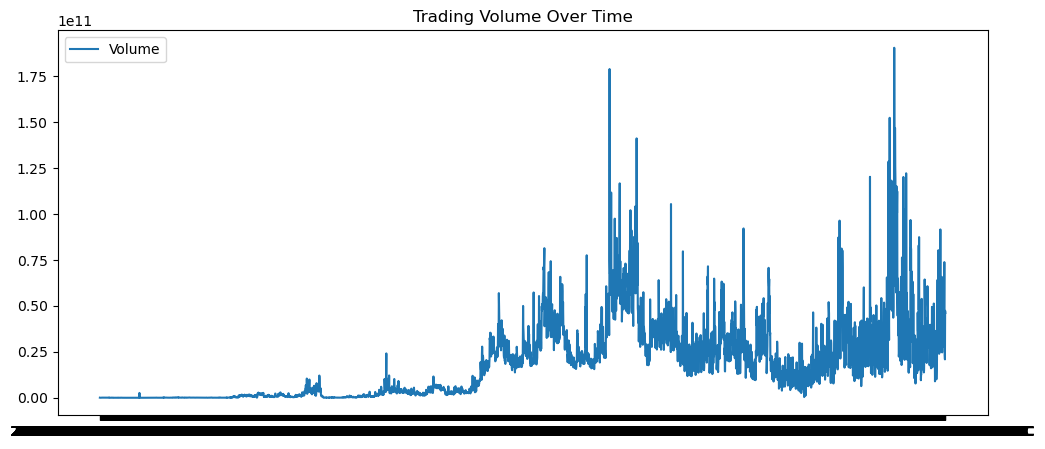

In [13]:
plt.figure(figsize=(12,5))
plt.plot(df_clean["Date"], df_clean["Volume"], label="Volume")
plt.title("Trading Volume Over Time")
plt.legend()
plt.show()

This chart shows how Bitcoin’s trading volume has exploded over time, moving from almost no activity in the early years to huge spikes in recent years. These sharp bursts of volume usually happen during big price swings—either when Bitcoin surges or crashes.

For DipDetectorML, this matters because sudden jumps in trading volume often signal panic selling or heavy speculation, both of which can precede major dips. By combining price data with volume patterns, the system can better detect crashes in real time and improve the accuracy of monthly dip forecasts.

Text(0.5, 1.0, 'Price distribution')

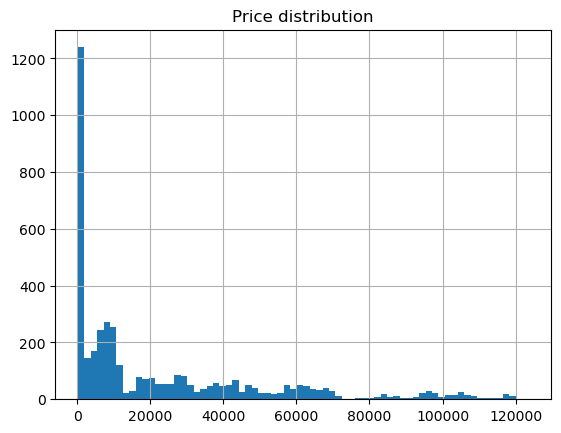

In [14]:
df_clean["Close"].hist(bins=70)
plt.title("Price distribution")

Most of the data is concentrated on the left side, where prices are lower (under $20,000). You can see a tall spike near zero, which tells us that for a long period in Bitcoin’s history, prices were very low compared to today.

Bitcoin spent the majority of its history at relatively low prices, while the very high prices we see today are much rarer but recent. This highlights both Bitcoin’s growth and how unusual its current valuation is compared to most of its past.

Text(0.5, 1.0, 'Volume distribution')

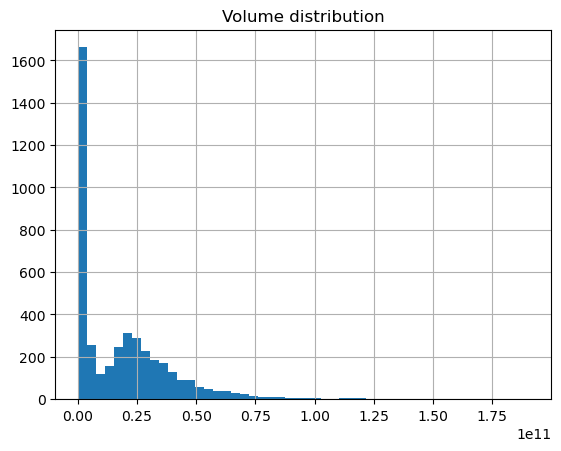

In [15]:
df_clean["Volume"].hist(bins=50)
plt.title("Volume distribution")

Most of the trading days had low trading volumes, clustered close to zero, which explains the tall spike at the far left. 

As trading volume increases, the frequency quickly drops off, meaning very high-volume trading days were rare. 

The long “tail” to the right shows that while extreme spikes in trading volume did happen, they were much less common compared to low and moderate activity.

### Connect it to ML 

By analyzing these distributions before training, we see potential issues. For example:

If the model only learns from the bulk of data (low price & low volume), it may miss the rare but important cases when price and volume surge together.

We may need to normalize, transform, or balance the data so the Random Forest doesn’t just focus on the most common ranges.

These insights also guide feature engineering — for instance, high trading volume days could be flagged as special indicators for predicting future price changes.

In [17]:
# Make a safe copy
df_clean = df_clean.copy()

# Ensure Date is datetime
df_clean["Date"] = pd.to_datetime(df_clean["Date"])



In [18]:
# Feature engineering
df_clean["return_1d"]  = df_clean["Close"].pct_change(1)
df_clean["return_7d"]  = df_clean["Close"].pct_change(7)
df_clean["volatility_7d"]  = df_clean["Close"].pct_change().rolling(7).std()
df_clean["m_averages_7"]    = df_clean["Close"].rolling(7).mean()
df_clean["m_averages_30"]   = df_clean["Close"].rolling(30).mean()
df_clean["momentum_30d"] = df_clean["Close"] / df_clean["Close"].shift(30) - 1

df_clean["month"] = df_clean["Date"].dt.month
df_clean["week"]  = df_clean["Date"].dt.isocalendar().week.astype(int)
